## Extend the off-resonant and single peak notebooks to multiple peaks

In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from mrs_denoising import denoising

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Copy the utility functions from the single on-resonance peak notebook
Modify the functions for multiple peaks. Set the omega parameter(s) to [-10, 300 and 800].

In [7]:
def fwd(x, c, alpha, omega, phi):
    return c * np.exp((alpha + 1j * omega) * x) * np.exp(1j * phi)

def generate_data(sigma, reps=1, linewidth=10, bandwidth=1000, points=512):
    dwelltime = 1 / bandwidth
    time_axis = np.arange(0.0, points*dwelltime, dwelltime)
    
    alpha = -np.pi * linewidth
    noiseless = fwd(time_axis, 1.0, alpha, -10, 0.0)
    noiseless += fwd(time_axis, 1.0, alpha, 300, 0.0)
    noiseless += fwd(time_axis, 1.0, alpha, 800, 0.0)
    
    noise = sigma/np.sqrt(2) * np.random.randn(reps,points)\
        + 1j * sigma/np.sqrt(2) * np.random.randn(reps,points)
    
    return noise + noiseless

def fit_func(x, c0, l0, o0, p0, c1, l1, o1, p1, c2, l2, o2, p2):
    cmplx = fwd(x[:int(x.size/2)], c0, -np.pi*l0, o0, p0)
    cmplx += fwd(x[:int(x.size/2)], c1, -np.pi*l1, o1, p1)
    cmplx += fwd(x[:int(x.size/2)], c2, -np.pi*l2, o2, p2)
    return np.concatenate((cmplx.real, cmplx.imag))

def fit_data(xdata, ydata):
    x0 = [1.0, 30.0, -10.0, 0.0,
          1.0, 30.0, 200.0, 0.0,
          1.0, 30.0, 400.0, 0.0]
    ydat = np.concatenate((ydata.real, ydata.imag))
    xdat = np.concatenate((xdata,xdata))
    xopt, xcov = curve_fit(fit_func, xdat, ydat, p0=x0)
    crlb = np.sqrt(np.diag(xcov))
                               
    return xopt, crlb

def FID2Spec(FID, axis=0):
    # By convention the first point of the fid is special-cased
    ss = [slice(None) for i in range(FID.ndim)]
    ss[axis] = slice(0, 1)
    ss = tuple(ss)
    FID[ss] *= 0.5
    out = np.fft.fftshift(
        np.fft.fft(FID,
                   axis=axis,
                   norm='ortho'),axes=axis)
    FID[ss] *= 2
    return out

### Example data and example fit

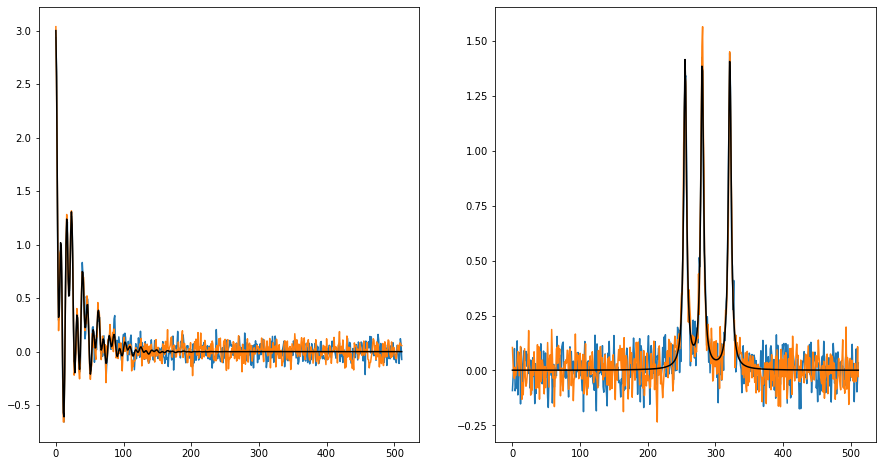

In [14]:
data = generate_data(0.1, reps=2)
data_noiseless = generate_data(0.0)
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,8))
ax1.plot(data.T.real)
ax1.plot(data_noiseless.T.real,'k')

ax2.plot(FID2Spec(data.T).real)
ax2.plot(FID2Spec(data_noiseless.T).real,'k')
plt.show()

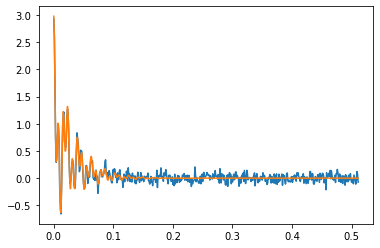

amplitude = 0.98±0.03, 1.01±0.03, 1.00±0.02
linewidth = 9.78±0.36, 10.11±0.37, 9.67±0.34
omega = -8.01±1.13, 298.71±1.17, 799.67±1.06
phi = -0.05±0.03, 0.00±0.03, 0.01±0.02


In [21]:
dwelltime = 1 / 1000
points = 512
t_axis = np.arange(0.0, points*dwelltime, dwelltime)

xout, x_sd = fit_data(t_axis, data[0,:])

c0, l0, o0, p0, c1, l1, o1, p1, c2, l2, o2, p2 = xout

plt.plot(t_axis,data[0,:].real)
plt.plot(t_axis,(fwd(t_axis,c0, -np.pi*l0, o0, p0)
                + fwd(t_axis,c1, -np.pi*l1, o1, p1)
                + fwd(t_axis,c2, -np.pi*l2, o2, p2)).real)
plt.show()
print(f'amplitude = {c0:0.2f}±{x_sd[0]:0.2f}, {c1:0.2f}±{x_sd[4]:0.2f}, {c2:0.2f}±{x_sd[8]:0.2f}')
print(f'linewidth = {l0:0.2f}±{x_sd[1]:0.2f}, {l1:0.2f}±{x_sd[5]:0.2f}, {l2:0.2f}±{x_sd[9]:0.2f}')
print(f'omega = {o0:0.2f}±{x_sd[2]:0.2f}, {o1:0.2f}±{x_sd[6]:0.2f}, {o2:0.2f}±{x_sd[10]:0.2f}')
print(f'phi = {p0:0.2f}±{x_sd[3]:0.2f}, {p1:0.2f}±{x_sd[7]:0.2f}, {p2:0.2f}±{x_sd[11]:0.2f}')

### Generate data for the rest of the notebook

In [22]:
data_shape = (8,8,1)
mc_rep = 50
noisy_data = generate_data(0.1, reps=np.prod(data_shape) * mc_rep)
noisy_data = noisy_data.reshape((mc_rep,) + data_shape + (512,))
noisy_data.shape

(50, 8, 8, 1, 512)

### Denoise using the global ST approach

In [23]:
# Global ST denoising, rank = 1
st_denoised = [denoising.st_denoising(nd,rank=1)[0] for nd in noisy_data]
st_denoised = np.asarray(st_denoised)

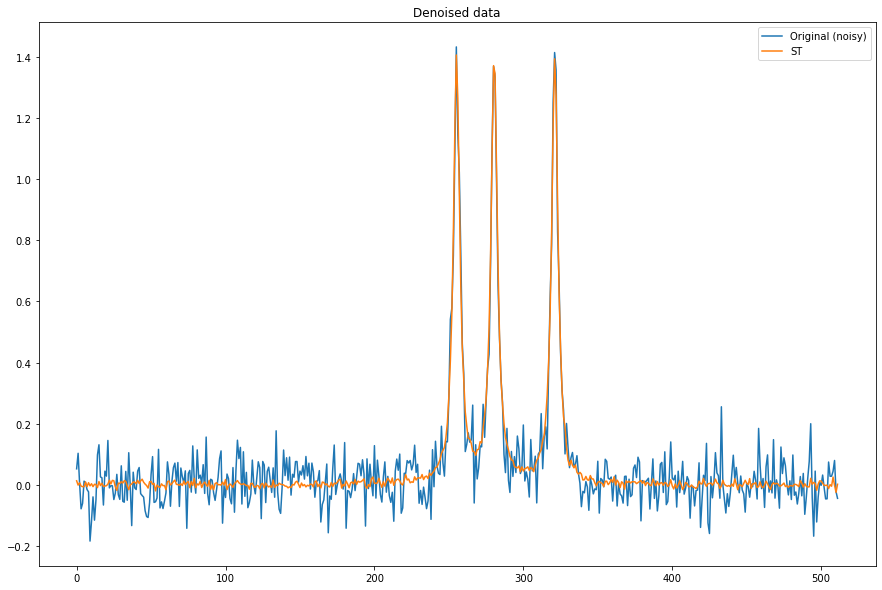

In [24]:
fig = plt.figure(figsize=(15,10))
plt.plot(FID2Spec(noisy_data,axis=4)[0,6,6,0,:].real, label='Original (noisy)')
plt.plot(FID2Spec(st_denoised,axis=4)[0,6,6,0,:].real, label='ST')
plt.legend()
plt.title('Denoised data')
plt.show()

### Variance after denoising

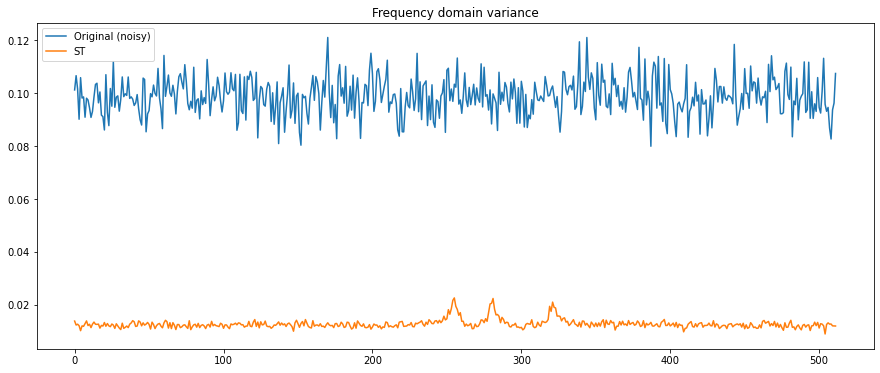

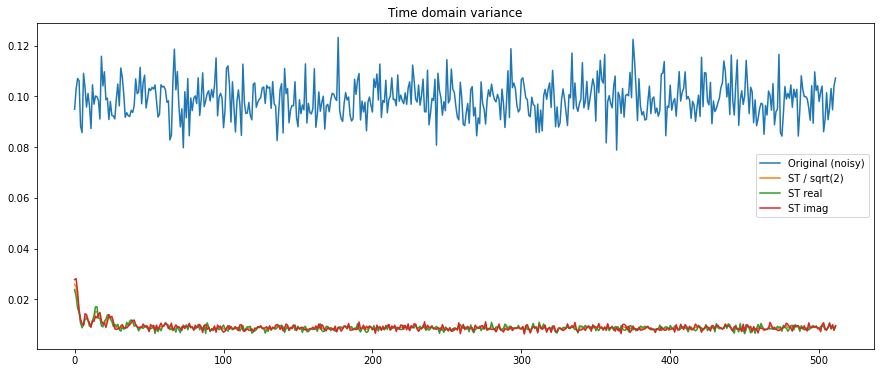

In [25]:
fig = plt.figure(figsize=(15,6))
plt.plot(np.std(FID2Spec(noisy_data,axis=4)[:,6,6,0,:],axis=0), label='Original (noisy)')
plt.plot(np.std(FID2Spec(st_denoised,axis=4)[:,6,6,0,:],axis=0), label='ST')
plt.title('Frequency domain variance')
plt.legend()
plt.show()

fig = plt.figure(figsize=(15,6))
plt.plot(np.std(noisy_data[:,6,6,0,:],axis=0), label='Original (noisy)')
plt.plot(np.std(st_denoised[:,6,6,0,:],axis=0)/np.sqrt(2), label='ST / sqrt(2)')
plt.plot(np.std(st_denoised[:,6,6,0,:].real,axis=0), label='ST real')
plt.plot(np.std(st_denoised[:,6,6,0,:].imag,axis=0), label='ST imag')
plt.title('Time domain variance')
plt.legend()
plt.show()

### What is the fitting estimated variance compared to the MC estimated variance?

In [36]:
noisy_param, noisy_sd = [], []
gst_param, gst_sd = [], []

for nd, g_st,  in zip(noisy_data,st_denoised):
    xout, x_sd = fit_data(t_axis, nd[4,4,0,:])
    noisy_param.append(xout)
    noisy_sd.append(x_sd)
    
    xout, x_sd = fit_data(t_axis, g_st[4,4,0,:])
    gst_param.append(xout)
    gst_sd.append(x_sd)
    
    
noisy_param = np.asarray(noisy_param)
noisy_sd = np.asarray(noisy_sd)
gst_param = np.asarray(gst_param)
gst_sd = np.asarray(gst_sd)

print(f'Noisy (mc/est): {noisy_param.std(axis=0)[0]:0.3f}/{noisy_sd.mean(axis=0)[0]:0.3f}, {noisy_param.std(axis=0)[4]:0.3f}/{noisy_sd.mean(axis=0)[4]:0.3f}, {noisy_param.std(axis=0)[8]:0.3f}/{noisy_sd.mean(axis=0)[8]:0.3f} ')
print(f'Global ST (mc/est): {gst_param.std(axis=0)[0]:0.3f}/{gst_sd.mean(axis=0)[0]:0.3f}, {gst_param.std(axis=0)[4]:0.3f}/{gst_sd.mean(axis=0)[4]:0.3f}, {gst_param.std(axis=0)[8]:0.3f}/{gst_sd.mean(axis=0)[8]:0.3f} ')

Noisy (mc/est): 0.027/0.027, 0.024/0.027, 0.024/0.025 
Global ST (mc/est): 0.011/0.003, 0.011/0.003, 0.011/0.003 


### How well can we estimate the variance?

(0.0, 0.001)

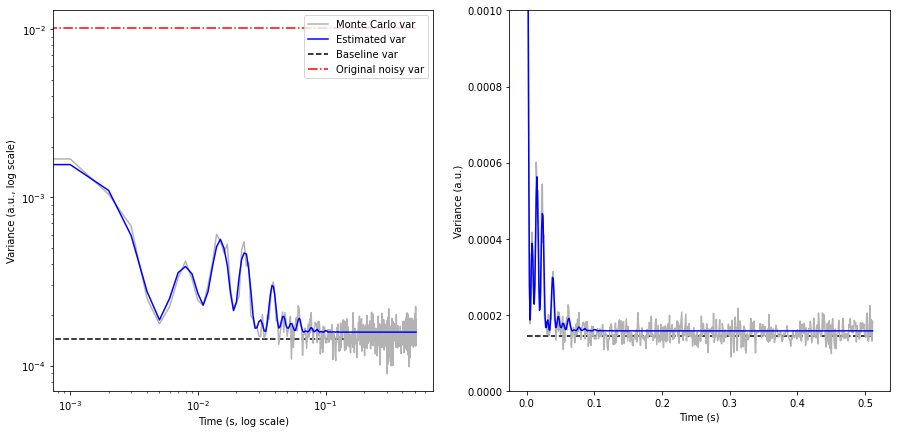

In [38]:
_,st_var,st_cov = denoising.st_denoising(noisy_data[0],rank=1)
st_var *= np.var(noisy_data[0, 4, 4, 0, 300:512])
dwelltime = 1 / 1000
points = 512
t_axis = np.arange(0.0, points*dwelltime, dwelltime)

def plot_var2(ax,all_data,est_var,xrange_noise, noisy_var, labels=[None, None, None, None]):
    std = np.var(all_data[:,4,4,0,:], axis=0)
    std2 = np.var(all_data[0,4,4,0, xrange_noise])
    ax.plot(t_axis, std,color=[0.7, 0.7, 0.7], label=labels[0])
    ax.plot(t_axis, est_var[4,4,0,:],'b',label=labels[1])
    ax.hlines(std2, t_axis[0], t_axis[-1],'k',linestyle='--',label=labels[2])
    ax.hlines(noisy_var, t_axis[0], t_axis[-1],'r',linestyle='-.',label=labels[3])
    ax.set_xscale('log')
    ax.set_yscale('log')

noise_slice = slice(300,512)
noisy_var = np.var(noisy_data[0, 4, 4, 0, 300:512])

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
plot_var2(ax1,st_denoised,st_var,noise_slice, noisy_var,
          labels = ['Monte Carlo var',
                    'Estimated var',
                    'Baseline var',
                    'Original noisy var'])
plot_var2(ax2,st_denoised,st_var,noise_slice, noisy_var,
          labels = ['Monte Carlo var',
                    'Estimated var',
                    'Baseline var',
                    'Original noisy var'])
ax1.set_ylabel('Variance (a.u., log scale)')
ax1.set_xlabel('Time (s, log scale)')
ax1.legend()

ax2.set_xscale('linear')
ax2.set_yscale('linear')
ax2.set_ylabel('Variance (a.u.)')
ax2.set_xlabel('Time (s)')
ax2.set_ylim([0,0.001])

### And the covariance?
Note the conjugation of the estimated covariance

Text(0.5, 1.0, 'ST Imag')

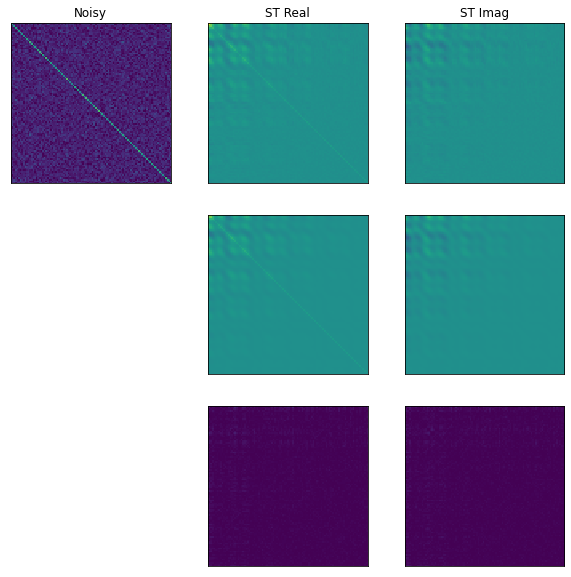

In [41]:
mc_covar_noisy = np.cov(noisy_data[:,4,4,0,:].T)
mc_covar_st_denoised = np.cov(st_denoised[:,4,4,0,:].T)

_,st_var,st_cov = denoising.st_denoising(noisy_data[0],rank=1)
st_var *= noisy_var

st_cov = st_cov.conj()
st_cov *= noisy_var
st_cov -= np.diag(np.diag(st_cov))
st_cov += np.diag(st_var[4,4,0,:]) 

def plot_mat(ax, data, vmin, vmax):
    im = ax.matshow(data, vmin=vmin , vmax=vmax)
    ax.set_xlim([0, 100])
    ax.set_ylim([100, 0])
    ax.set_xticks([])
    ax.set_yticks([])
    return im

vmax = np.max(np.abs(mc_covar_st_denoised))
vmin = -1*vmax
fig, axes = plt.subplots(3,3,figsize=(10,10))
plot_mat(axes[0,0], mc_covar_noisy.real, vmin, vmax*10)
plot_mat(axes[0,1], mc_covar_st_denoised.real, vmin, vmax)
plot_mat(axes[0,2], mc_covar_st_denoised.imag, vmin, vmax)

axes[1,0].axis('off')
plot_mat(axes[1,1], st_cov.real, vmin, vmax)
plot_mat(axes[1,2], st_cov.imag, vmin, vmax)

axes[2,0].axis('off')
plot_mat(axes[2,1], np.abs(st_cov.real-mc_covar_st_denoised.real), 0, vmax)
plot_mat(axes[2,2], np.abs(st_cov.imag-mc_covar_st_denoised.imag), 0, vmax)

axes[0,0].set_title('Noisy')
axes[0,1].set_title('ST Real')
axes[0,2].set_title('ST Imag')

### Separate real and imaginary components to form a single covariance matrix
If we try to bootstrap using the two channels (real/imaginary) separately we loose the 
fixed phase relationship between the channels.

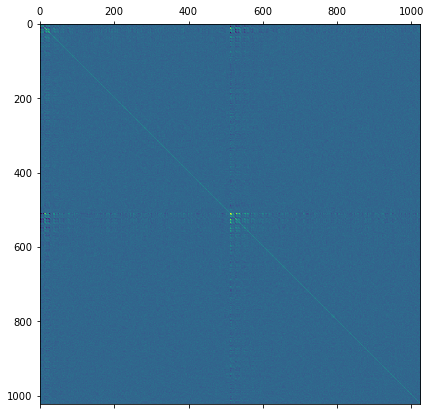

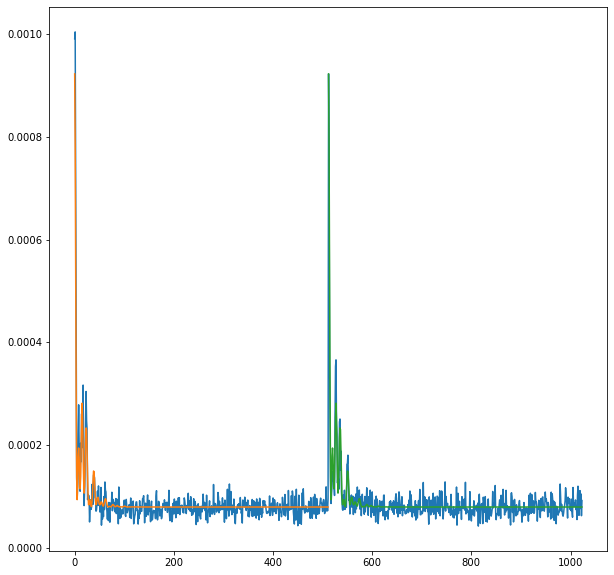

In [50]:
# Aim for the following
ri_st = np.concatenate((st_denoised[:,4,4,0,:].T.real,st_denoised[:,4,4,0,:].T.imag))
ri_st_cov = np.cov(ri_st)
vmax = np.max(np.abs(ri_st_cov))/2
vmin = -1*vmax/2
fig = plt.figure(figsize=(7,7))
fig.gca().matshow(ri_st_cov,vmin=vmin , vmax=vmax)
plt.show()

ri_noise = np.concatenate((noisy_data[:,4,4,0,:].T.real,noisy_data[:,4,4,0,:].T.imag))
ri_noise_cov = np.cov(ri_noise)
# vmax = np.max(np.abs(ri_noise_cov))/2
# vmin = -1*vmax/2
# fig = plt.figure(figsize=(7,7))
# fig.gca().matshow(ri_noise_cov,vmin=vmin , vmax=vmax)

# Is the split variance (cov diagonal) simply the variance split up as well?
fig = plt.figure(figsize=(10,10))
plt.plot(np.diag(ri_st_cov))
plt.plot(np.arange(0,512), st_var[4,4,0,:]/2)
plt.plot(np.arange(512,1024), st_var[4,4,0,:]/2)
plt.show()
# Yes

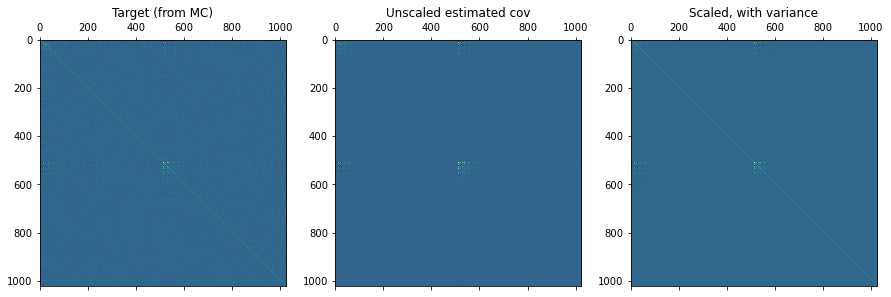

In [44]:
_,est_var,two_cha_cov = denoising.st_denoising(noisy_data[0],rank=1)

est_split_cov = np.block([[two_cha_cov.real,two_cha_cov.imag],[two_cha_cov.imag.T,two_cha_cov.real]])

fig,(ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,7))
vmax = np.max(np.abs(ri_st_cov))/2
vmin = -1*vmax/2
ax1.matshow(ri_st_cov,vmin=vmin , vmax=vmax)
ax2.matshow(est_split_cov,vmin=np.min(est_split_cov)/2,vmax=np.max(est_split_cov)/2)

heuristic_split_cov = est_split_cov.copy()
heuristic_split_cov -= np.diag(np.diag(heuristic_split_cov))
heuristic_split_cov += np.diag(np.concatenate((est_var[4,4,0,:], est_var[4,4,0,:])))
heuristic_split_cov *= noisy_var/2

vmax = np.max(np.abs(ri_st_cov))/2
vmin = -1*vmax/2

ax3.matshow(heuristic_split_cov,vmin=vmin , vmax=vmax)

ax1.set_title('Target (from MC)')
ax2.set_title('Unscaled estimated cov')
ax3.set_title('Scaled, with variance')

plt.show()


### Check that the bootstrapped data has the same variance profile as the original (MC) data

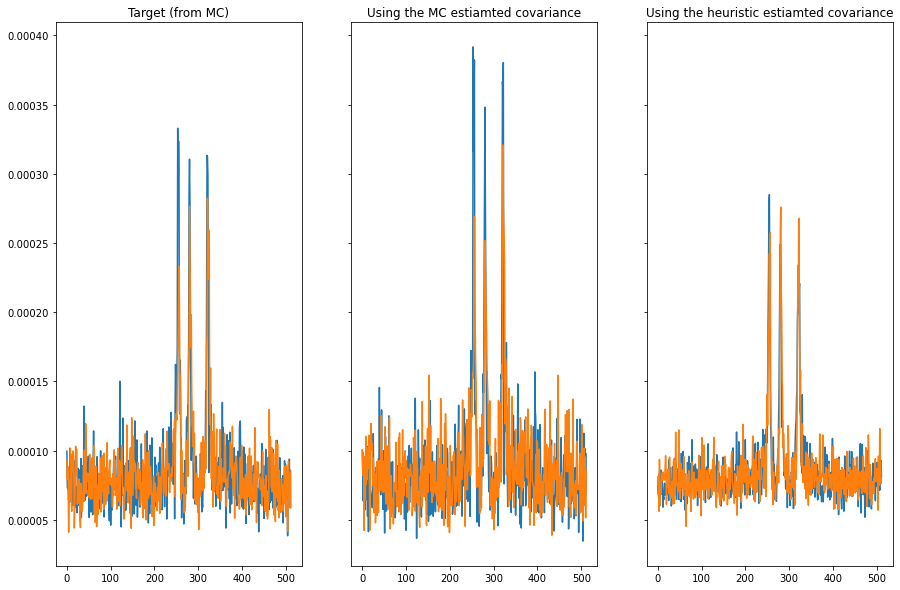

In [48]:
rng = np.random.default_rng()
def boostrap_gen_ri(data, covar):
    shape = data.size
    peturbed = rng.multivariate_normal(np.concatenate((data.real, data.imag)),
                                       covar,
                                       check_valid='ignore')
    return peturbed[:shape] + 1j * peturbed[shape:]

# fids_split = []
# for idx in range(100):
#     fids_split.append(boostrap_gen_ri(st_denoised[0,4,4,0,:], ri_st_cov))
# fids_split = np.asarray(fids_split)

# fids_split2 = []
# for idx in range(100):
#     fids_split2.append(boostrap_gen_ri(st_denoised[0,4,4,0,:], heuristic_split_cov))
# fids_split2 = np.asarray(fids_split2)

fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,10),sharey=True)
ax1.plot(np.var(FID2Spec(st_denoised[:,4,4,0,:].T).real,axis=1))
ax1.plot(np.var(FID2Spec(st_denoised[:,4,4,0,:].T).imag,axis=1))

ax2.plot(np.var(FID2Spec(fids_split.T).real,axis=1))
ax2.plot(np.var(FID2Spec(fids_split.T).imag,axis=1))

ax3.plot(np.var(FID2Spec(fids_split2.T).real,axis=1))
ax3.plot(np.var(FID2Spec(fids_split2.T).imag,axis=1))

ax1.set_title('Target (from MC)')
ax2.set_title('Using the MC estiamted covariance')
ax3.set_title('Using the heuristic estiamted covariance')

plt.show()

### Bootstrap fitting test

In [51]:
def boot_strap_fit(data, covar, reps=50):
    xout = []
    for idx in range(reps):
        cov_petub = boostrap_gen_ri(data, covar)
        xout.append(fit_data(t_axis, cov_petub)[0])
    return np.mean(xout, axis=0), np.std(xout, axis=0)


print('\nFrom MC covariance')
x_bs_noisy, x_std_bs_noisy = boot_strap_fit(generate_data(0.0)[0,:], ri_noise_cov, reps=100)
x_bs_st, x_std_bs_st = boot_strap_fit(st_denoised[0,4,4,0,:], ri_st_cov, reps=100)

print(f'Noisy (mc/est/bs): {noisy_param.std(axis=0)[0]:0.3f}/{noisy_sd.mean(axis=0)[0]:0.3f}/{x_std_bs_noisy[0]:0.3f}, '
      f'{noisy_param.std(axis=0)[4]:0.3f}/{noisy_sd.mean(axis=0)[4]:0.3f}/{x_std_bs_noisy[4]:0.3f}, '
      f'{noisy_param.std(axis=0)[8]:0.3f}/{noisy_sd.mean(axis=0)[8]:0.3f}/{x_std_bs_noisy[8]:0.3f}.')
print(f'Global ST (mc/est/bs): {gst_param.std(axis=0)[0]:0.3f}/{gst_sd.mean(axis=0)[0]:0.3f}/{x_std_bs_st[0]:0.3f}, '
      f'{gst_param.std(axis=0)[4]:0.3f}/{gst_sd.mean(axis=0)[4]:0.3f}/{x_std_bs_st[4]:0.3f}, '
      f'{gst_param.std(axis=0)[8]:0.3f}/{gst_sd.mean(axis=0)[8]:0.3f}/{x_std_bs_st[8]:0.3f}.')

print('\nFrom estimated covariance')
x_bs_st, x_std_bs_st = boot_strap_fit(st_denoised[0,4,4,0,:], heuristic_split_cov, reps=100)
print(f'Global ST (mc/est/bs): {gst_param.std(axis=0)[0]:0.3f}/{gst_sd.mean(axis=0)[0]:0.3f}/{x_std_bs_st[0]:0.3f}, '
      f'{gst_param.std(axis=0)[4]:0.3f}/{gst_sd.mean(axis=0)[4]:0.3f}/{x_std_bs_st[4]:0.3f}, '
      f'{gst_param.std(axis=0)[8]:0.3f}/{gst_sd.mean(axis=0)[8]:0.3f}/{x_std_bs_st[8]:0.3f}.')


From MC covariance
Noisy (mc/est/bs): 0.027/0.027/0.025, 0.024/0.027/0.026, 0.024/0.025/0.024.
Global ST (mc/est/bs): 0.011/0.003/0.011, 0.011/0.003/0.011, 0.011/0.003/0.010.

From estimated covariance
Global ST (mc/est/bs): 0.011/0.003/0.011, 0.011/0.003/0.010, 0.011/0.003/0.010.
